# Activations recorded

## Prep Functions- show images

In [67]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from time import time
from torch.utils.data import Dataset

In [2]:
def plot_accuracy_loss(training_results):
    plt.subplot(2, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    plt.subplot(2, 1, 2)
    plt.plot(training_results['validation_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.show()

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))
    plt.show()

def show_dataComp(data_sample,y):
    plt.subplot(1,2,1)
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(data_sample[1].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(y))

    plt.show()

## Img Pairing and Data Prep

1) traindataComp-trainloader: consecutive data pairs from the training set <br>
2) valdataComp-valloader: consecutive data pairs from the test set <br>
3) testdata- testloader: all data pairs from test set- keeps track of the pair <br>

In [3]:
def indlist(target):
    indlist = [[],[],[],[],[]]
    
    for i in range(len(target)):
        if target[i] < 5:
            indlist[target[i]].append(i)
    return indlist

def subData(dataSet):
    #gets all the indices of the data obsv with same y from the dataset that is passed in only for 0-4
    indices = indlist(dataSet.targets)
    # a list of datasets where each dataset has the data for the same number
    subsets = []
    [subsets.append(torch.utils.data.Subset(dataSet, i)) for i in indices]
    return subsets
    

In [4]:
def comparisonDataConsecutive(dataSet):
    subsets = subData(dataSet)
    # a list of the size of the possible pairs
    comp = []
    for indi in range(len(subsets) - 1):
        comp.append(int(min(len(subsets[indi]), len(subsets[indi + 1]))))
    tot1 = sum(comp)
    # img pair data stored
    x = torch.zeros([tot1, 2, 28, 28], dtype=torch.float32)
    # greater than or less than label stored
    y = torch.zeros([tot1,1])
    # 1 for first pic greater, 0 for first pic less
    k = 0
    # does the actual pairing
    for i in range(len(subsets) - 1):
        for j in range(int(comp[i] / 2)):
            x[k][0] = subsets[i][j][0]
            x[k][1] = subsets[i + 1][j][0]
            y[k][0] = 0
            k += 1
        for j in range(int(comp[i] / 2), comp[i]):
            x[k][1] = subsets[i][j][0]
            x[k][0] = subsets[i + 1][j][0]
            y[k][0] = 1
            k += 1
    return x,y

In [5]:
def comparisonDataNonconsecutive(dataSet):
    subsets = subData(dataSet)
    # a dictionary of pairs and the size of the pairings
    comp = {}
    
    for i in range(len(subsets) - 2):
        for j in range(i + 2, len(subsets), 1):
            comp[(i, j)] = int(min(len(subsets[i]), len(subsets[j])))
    tot = sum(comp.values())
    # greater than or less than label stored
    x = torch.zeros([tot, 2, 28, 28], dtype=torch.float32)
    # 1 for first pic greater, 0 for first pic less
    y = torch.zeros([tot, 1])
    k = 0
    #the pairing
    for key, values in comp.items():
        for value in range(int(values / 2)):
            x[k][0] = subsets[key[0]][value][0]
            x[k][1] = subsets[key[1]][value][0]
            y[k][0] = 0
            k += 1
        for value in range(int(values / 2), values):
            x[k][0] = subsets[key[1]][value][0]
            x[k][1] = subsets[key[0]][value][0]
            y[k][0] = 1
            k += 1
    return x,y


In [6]:
def comparisonAll(dataSet):
    subsets = subData(dataSet)
    # a dictionary of pairs(tuple) and the size of the pairings
    comp = {}
    for i in range(len(subsets) - 1):
        for j in range(i + 1, len(subsets), 1):
            comp[(i, j)] = int(min(len(subsets[i]), len(subsets[j])))
    #print(len(comp.keys()))
    #print(comp.keys())
    tot = sum(comp.values())
    # greater than or less than label stored
    x = torch.zeros([tot, 2, 28, 28], dtype=torch.float32)
    # 1 for first pic greater, 0 for first pic less
    y = torch.zeros([tot, 1])
    z = list()
    k = 0
    # the pairining
    for key, values in comp.items():
        for value in range(int(values / 2)):
            x[k][0] = subsets[key[0]][value][0]
            x[k][1] = subsets[key[1]][value][0]
            y[k][0] = 0
            z.append(key)
            k += 1
        for value in range(int(values / 2), values):
            x[k][0] = subsets[key[1]][value][0]
            x[k][1] = subsets[key[0]][value][0]
            y[k][0] = 1
            a = key[0]
            b = key[1]
            c = (b,a)
            z.append(c)
            k += 1
    return x,y,z

In [7]:
class Trainsetcomp(Dataset):
    def __init__(self, x, y):
        self.len = (x.shape[0])
        self.x = x
        self.y = y 

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return self.len

In [8]:
class TrainsetcompwithA(Dataset):
    def __init__(self, x, y, z):
        self.len = (x.shape[0])
        self.x = x
        self.y = y 
        #the pair
        self.z = z

    def __getitem__(self, index):
        return (self.x[index], self.y[index], self.z[index])

    def __len__(self):
        return self.len

In [9]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),])

trainset = dsets.MNIST(root='./../data',
                            train=True,
                            download=True,
                            transform=transform)
valset = dsets.MNIST(root='./../data',
                            train=False,
                            download=True,
                            transform=transform)

In [10]:
x, y = comparisonDataConsecutive(trainset)
traindataComp = Trainsetcomp(x,y)
x,y = comparisonDataConsecutive(valset)
valdataComp = Trainsetcomp(x,y)

In [11]:
trainloader = torch.utils.data.DataLoader(traindataComp,
                                          batch_size=64,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valdataComp,
                                          batch_size=64,
                                          shuffle=True)
x,y,z = comparisonAll(valset)
testdata = TrainsetcompwithA(x,y,z)
testloader = torch.utils.data.DataLoader(testdata,
                                          batch_size=64,
                                          shuffle=F)
# in the test loader: z is a list of size 2 of two [64] shape tensors. - it turned the tuple into a list of tensors

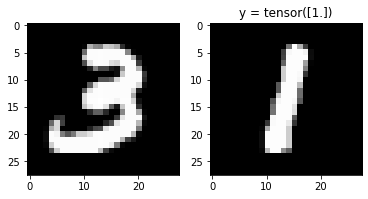

tensor(3) tensor(1)


In [12]:
## showing what the z in the test loader is- ignore
i = 1
j = 0
for x,y,z in testloader:
    j+=1
    p = x[i,:,:,:]
    show_dataComp(p,y[i,:])
    #print(z)
    print(z[0][i],z[1][i])
    if j >= 1:
        break

## Model

In [13]:
ind = 2 * 28 * 28
hiddendim = [400,200,64]
outd = 1
# 0 if first image is less than and 1 if frist image is greater than

In [14]:
class ModelFull(nn.Module):
    def __init__(self, ind,h1d,h2d,h3d,outd):
        super(ModelFull, self).__init__()
        self.lin1 = nn.Linear(ind, h1d)
        self.lin2 = nn.Linear(h1d, h2d)
        self.lin3 = nn.Linear(h2d, h3d)
        self.lin4 = nn.Linear(h3d, outd)
        self.activations = []
        self.pairs = []

    def forward(self, x, recActivations = False):
        if recActivations:
            x1 = torch.relu(self.lin1(x))
            x2 = torch.relu(self.lin2(x1))
            x3 = torch.relu(self.lin3(x2))
            self.activations.append(x3)
            x4 = torch.sigmoid(self.lin4(x3))
            return x4
        else:
            x1 = torch.relu(self.lin1(x))
            x2 = torch.relu(self.lin2(x1))
            x3 = torch.relu(self.lin3(x2))
            x4 = torch.sigmoid(self.lin4(x3))
            return x4
        
    def setPair(self, pair):
        self.pairs.append(pair)

In [15]:
def train(model, criterion, optimizer, epochs = 30):
    lossList = []
    #time0 = time()
    for i in range(epochs):
        runningLoss = 0
        for x, y in trainloader:
            optimizer.zero_grad()
            yhat = model(x.view(-1, 2 * 28 *28))
            #print(yhat.shape)
            #print(y.shape)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            runningLoss += loss.item()
        print('epoch ', i, ' loss: ', str(runningLoss / len(traindataComp)))
        lossList.append(runningLoss / len(traindataComp))
    return lossList

In [16]:
model = ModelFull(ind,hiddendim[0],hiddendim[1],hiddendim[2], outd)

In [17]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)
results = train(model,criterion,optimizer,25)

epoch  0  loss:  0.008382898135210865
epoch  1  loss:  0.0037076317893083113
epoch  2  loss:  0.0017978798901052413
epoch  3  loss:  0.0013567086444954267
epoch  4  loss:  0.001148785877678315
epoch  5  loss:  0.0009722499657878665
epoch  6  loss:  0.0009141856029918452
epoch  7  loss:  0.000826726587953945
epoch  8  loss:  0.014102130020917843
epoch  9  loss:  0.0008667411049955749
epoch  10  loss:  0.0007640555097028285
epoch  11  loss:  0.0006042474285051855
epoch  12  loss:  0.0005407521613680795
epoch  13  loss:  0.0005119333132595079
epoch  14  loss:  0.0003992040380334615
epoch  15  loss:  0.00034035448462118196
epoch  16  loss:  0.00034657194945411787
epoch  17  loss:  0.00027034474367135903
epoch  18  loss:  0.00021773700629177279
epoch  19  loss:  0.0002021162805267537
epoch  20  loss:  0.00046017364506392705
epoch  21  loss:  0.00021771397766885266
epoch  22  loss:  9.890810406107606e-05
epoch  23  loss:  8.204218072101346e-05
epoch  24  loss:  8.750546223402011e-05


In [20]:
## consecutive test set
totcount = 0
correctcount = 0
for x,y in valloader:
    x = x.view(-1, 2 * 28 *28)
    with torch.no_grad():
        yhat = model(x)
    ones = torch.ones(yhat.shape)
    yhat = torch.where(yhat>.5, ones, yhat)
    z = torch.zeros(yhat.shape)
    yhat = torch.where(yhat<0.5, z, yhat)
    wrongC = 0
    for i in range(len(y)):
        #print(i)
        if yhat[i][0] == y[i][0]:
            correctcount+=1
            #p = torch.reshape(x[i], (2,28,28))
            #show_dataComp(p, y[i])
            
        else:
            #if wrongC < 2:
                #p = torch.reshape(x[i], (2,28,28))
                #show_dataComp(p, yhat[i])
            wrongC += 1
        totcount+=1
print(correctcount)
print(totcount)
print('val set accuracy: ', correctcount/totcount)

3938
4004
val set accuracy:  0.9835164835164835


In [21]:
## test data set where activations are recorded
totcount = 0
correctcount = 0
for x,y,z in testloader:
    x = x.view(-1, 2 * 28 *28)
    with torch.no_grad():
        yhat = model(x,True)
    model.setPair(z)
    ones = torch.ones(yhat.shape)
    yhat = torch.where(yhat>.5, ones, yhat)
    z = torch.zeros(yhat.shape)
    yhat = torch.where(yhat<0.5, z, yhat)
    wrongC = 0
    for i in range(len(y)):
        #print(i)
        if yhat[i][0] == y[i][0]:
            correctcount+=1
            #p = torch.reshape(x[i], (2,28,28))
            #show_dataComp(p, y[i])
            
        else:
            #if wrongC < 2:
                #p = torch.reshape(x[i], (2,28,28))
                #show_dataComp(p, yhat[i])
            wrongC += 1
        totcount+=1
print(correctcount)
print(totcount)
print('test set accuracy: ', correctcount/totcount)

9385
9918
test set accuracy:  0.9462593264771123


In [22]:
len(testdata)
print(len(testloader))
print(model.activations[0].shape)
print(len(model.pairs))
print(model.pairs[0][1].shape)
print(model.activations[0])
print(model.pairs[1])

155
torch.Size([64, 64])
155
torch.Size([64])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.6243, 0.0000],
        [0.2007, 0.3744, 0.8346,  ..., 2.0164, 0.0000, 1.2833],
        [0.2168, 0.8350, 1.6269,  ..., 3.5839, 0.0000, 2.1864],
        ...,
        [0.1197, 0.2329, 0.5883,  ..., 1.1128, 0.3726, 0.7484],
        [0.0199, 0.4503, 1.0324,  ..., 2.0922, 0.0000, 1.5032],
        [0.1765, 0.6477, 1.5358,  ..., 3.1731, 0.0000, 2.1840]])
[tensor([2, 0, 2, 3, 0, 4, 1, 1, 2, 0, 2, 2, 2, 4, 3, 0, 3, 2, 2, 1, 1, 2, 2, 2,
        1, 1, 3, 1, 4, 4, 4, 1, 2, 4, 4, 1, 4, 1, 3, 2, 3, 4, 3, 3, 0, 2, 2, 2,
        0, 4, 3, 0, 4, 3, 4, 4, 2, 2, 0, 4, 3, 0, 3, 1]), tensor([0, 4, 4, 4, 1, 2, 2, 3, 0, 1, 3, 4, 3, 3, 1, 3, 4, 0, 4, 0, 2, 4, 4, 3,
        0, 2, 1, 0, 2, 2, 0, 4, 1, 2, 0, 0, 2, 2, 1, 4, 0, 3, 2, 4, 3, 4, 0, 4,
        1, 2, 4, 2, 2, 0, 3, 2, 3, 3, 3, 0, 4, 2, 1, 4])]


## RSA preprocess

In [25]:
# creates a dictionary of keys- the pair and values- the activations
activationsDict = {}
for pair,activ in zip(model.pairs, model.activations):
    for i in range(len(pair[0])):
        p1= pair[0][i].item()
        p2 = pair[1][i].item()
        key1 = (p1,p2)
        val = activ[i,:].numpy()
        if key1 in activationsDict:
            cur = activationsDict[key1]
            cur.append(val)
        else:
            activationsDict[key1]= []
            cur = activationsDict[key1]
            cur.append(val)
for key in activationsDict.keys():
    rep = np.array(activationsDict[key])
    activationsDict[key] = rep
#check that all samples are included    

tota = 0
for key in activationsDict.keys():
    #print(key)
    tota +=len(activationsDict[key])
print(len(testdata))
print(tota)

9918
9918


In [26]:
# creates a dictionary of keys- the pair and values- the activations
avgDict = {}
for key in activationsDict:
    a = np.mean(activationsDict[key], axis=0)
    avgDict[key] = a
print (len(avgDict.keys()))


20


In [55]:
sortedKeys = sorted(avgDict)
print(sortedKeys)
sortedMatrix = np.empty([20,64])
sortedMatrixUnit = np.empty([20,64])
for i in range(20):
    key = sortedKeys[i]
    sortedMatrix[i] = avgDict[key]
    sortedMatrixUnit[i] =  avgDict[key]/np.linalg.norm(avgDict[key])
print(sortedMatrixUnit)

[(0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3)]
[[0.00675299 0.07248668 0.16598204 ... 0.33933297 0.00239751 0.24483579]
 [0.01689213 0.06291376 0.16976649 ... 0.32297871 0.04193724 0.22600915]
 [0.01880461 0.05554073 0.16148542 ... 0.33014902 0.00290902 0.22949117]
 ...
 [0.00059003 0.00324804 0.01239095 ... 0.01320659 0.15592457 0.01079828]
 [0.00074775 0.0030376  0.01025293 ... 0.01452437 0.15323251 0.01043148]
 [0.00037654 0.00034617 0.00179504 ... 0.0045538  0.14905293 0.0036913 ]]


In [56]:
sortbypair = [(0,1), (1,0), (0, 2), (2, 0), (0, 3), (3, 0), (0, 4), (4, 0), (1, 2), (2, 1), (1, 3), (3, 1), 
              (1, 4), (4, 1), (2, 3), (3, 2), (2, 4), (4, 2), (3, 4), (4, 3)]
print(len(sortbypair))
sortedPairMatrix = np.empty([20,64])
sortedPairMatrixUnit = np.empty([20,64])
for i in range(20):
    key = sortbypair[i]
    sortedPairMatrix[i] = avgDict[key]
    sortedPairMatrixUnit[i] =  avgDict[key]/np.linalg.norm(avgDict[key])
print(sortedPairMatrix)

20
[[5.04709519e-02 5.41755915e-01 1.24052787e+00 ... 2.53612971e+00
  1.79186705e-02 1.82987034e+00]
 [6.78046665e-04 3.50546604e-03 9.36566573e-03 ... 2.19688434e-02
  1.40790558e+00 2.45573744e-02]
 [8.04480389e-02 2.99624085e-01 8.08505595e-01 ... 1.53817213e+00
  1.99724317e-01 1.07635880e+00]
 ...
 [5.17019350e-03 2.10028924e-02 7.08918348e-02 ... 1.00425780e-01
  1.05949509e+00 7.21263289e-02]
 [7.63417482e-02 5.27123332e-01 1.06885064e+00 ... 2.18348479e+00
  2.11336929e-02 1.45686960e+00]
 [3.34408786e-03 3.07438499e-03 1.59419011e-02 ... 4.04426605e-02
  1.32375085e+00 3.27827185e-02]]


In [76]:
lessGreater = [(0,1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4), (1,0), (2, 0), (3, 0), 
               (4, 0), (2, 1), (3, 1), (4, 1), (3, 2), (4, 2), (4, 3)]
print(len(lessGreater))
lgMatrix = np.empty([20,64])
lgMatrixUnit = np.empty([20,64])
centeredlg = np.empty([20,64])
for i in range(20):
    key = lessGreater[i]
    val = avgDict[key]
    mean = np.mean(val)
    val = val-mean
    centeredlg[i] = val/np.linalg.norm(val)
    lgMatrix[i] = avgDict[key]
    lgMatrixUnit[i] =  avgDict[key]/np.linalg.norm(avgDict[key])
    
print(centeredlg)

20
[[-0.06112472  0.01391653  0.12065034 ...  0.31854689 -0.06609692
   0.21066938]
 [-0.07763594 -0.01888277  0.11752994 ...  0.3131271  -0.04566228
   0.18933167]
 [-0.04821672 -0.0061483   0.11517438 ...  0.30831972 -0.06641957
   0.19305126]
 ...
 [-0.10060675 -0.09963987 -0.09553545 ... -0.09509675  0.12259312
  -0.09595702]
 [-0.1017231  -0.09875962 -0.08942167 ... -0.08389366  0.09561987
  -0.0891906 ]
 [-0.09813959 -0.09817827 -0.09633277 ... -0.0928188   0.09123748
  -0.0939174 ]]


## RSA

- calc similarity measures (380 each)
- see if the similarity measures are statistically significant
- where the structure is

### Calculating the similarity- cosine similarity/pearson correlation

- i dont think pearson is necessary because there shouldnt be shifts in data 

In [63]:
print(sortedMatrixUnit.shape)

def simMatrix(x):
    xt = np.transpose(x)
    return np.matmul(x,xt)

(20, 64)


(20, 20)


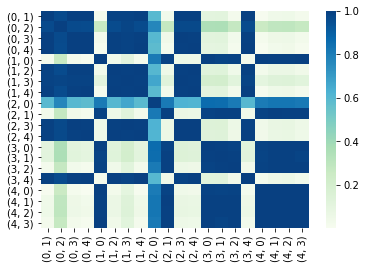

In [70]:
simSorted = simMatrix(sortedMatrixUnit)
print(simSorted.shape)
hm = sns.heatmap(simSorted, xticklabels=sortedKeys, yticklabels=sortedKeys, cmap="GnBu")

(20, 20)


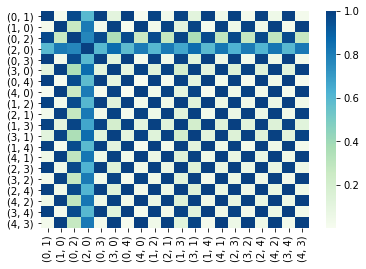

In [72]:
simSorted1 = simMatrix(sortedPairMatrixUnit)
print(simSorted1.shape)
hm = sns.heatmap(simSorted1, xticklabels=sortbypair, yticklabels=sortbypair, cmap="GnBu")

(20, 20)


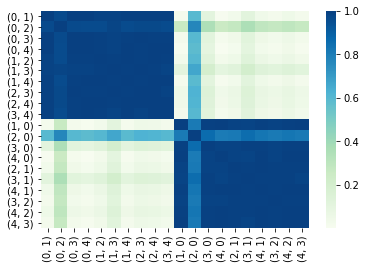

In [73]:
simSorted2 = simMatrix(lgMatrixUnit)
print(simSorted2.shape)
hm = sns.heatmap(simSorted2, xticklabels=lessGreater, yticklabels=lessGreater, cmap="GnBu")

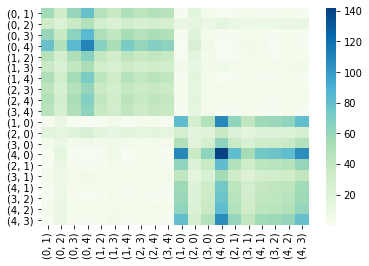

In [74]:
# dot product
sim = simMatrix(lgMatrix)
hm = sns.heatmap(sim, xticklabels=lessGreater, yticklabels=lessGreater, cmap="GnBu")